# Optimizing different aspecets of the working pipeline






## Import stuff

In [1]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git
!pip install torch
!pip install googlesearch-python
!pip install GoogleNews
!pip install textblob
!pip install schedule
!pip install time
!pip install telebot
!pip install telethon
!pip install transformers
!pip install vadersentiment
!pip install alpha_vantage
!pip install Prophet
!pip install tensorflow
!pip install optuna
!pip install --upgrade tensorflow
!pip install newsapi-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      S

In [2]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import schedule
import time
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from GoogleNews import GoogleNews
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

## Telegram Tokens

In [ ]:
# Include Telegram bot token and chat ID for pushing forecast results
BOT_TOKEN = "<BOT_TOKEN>"
chat_id = "<CHAT_ID>" 

# Data

## Numeric

In [3]:
def get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "3mo" #must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"
    interval = "1h"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info

    # Extract the market cap
    #market_cap = ticker_info['marketCap']

    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate the MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

#ticker = 'SPY'
#numeric = get_numeric_data(ticker)
#numeric.head()

# GRU forcast

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

def gru_forcast(target, df, future_days):
    print(target)
    num_mc_simulations=100
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[[target]]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the GRU model
    model = Sequential()
    model.add(GRU(units=1000, return_sequences=True, input_shape=(seq_len, 1)))
    model.add(Dropout(0.5))
    model.add(GRU(units=200, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(units=1000, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])
    #model.save('gru_model_pred-for.keras')

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Calculate actual prices
    actual_prices = close_df[seq_len:].values

    # Calculate MAE
    mae = np.mean(np.abs(actual_prices - predictions_rescaled))
    print(f'MAE: {mae:.2f}')

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean((actual_prices - predictions_rescaled) ** 2)) / np.mean(actual_prices) * 100
    print(f'RMSPE: {rmspe:.2f}%')

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    #future high
    future_close_prices_mc = []
    for _ in range(num_mc_simulations):
        future_close_prices = []
        last_seq_mc = scaled_close[-seq_len:]
        last_seq_mc = last_seq_mc.reshape((1, seq_len, 1))
        for i in range(future_days):
            predictions = model.predict(last_seq_mc, verbose=0)
            predictions_rescaled = scaler.inverse_transform(predictions)
            future_close_prices.append(predictions_rescaled[0, 0])
            predictions = predictions.reshape((1, 1, 1));  # Reshape predictions to (1, 1, 1)
            last_seq_mc = np.append(last_seq_mc[:, 1:, :], predictions, axis=1)
        future_close_prices_mc.append(future_close_prices)

    # Calculate the Monte Carlo average
    future_close_prices_mc_avg = np.mean(future_close_prices_mc, axis=0)

    # Plot forecasted prices
    plt.plot(close_df[seq_len:], label='Actual')
    #plt.plot(predictions_rescaled, label='Predicted')
    plt.plot(range(len(close_df[seq_len:]), len(close_df[seq_len:])+future_days), future_close_prices_mc_avg, label='Forecasted (MC Average)')
    plt.legend()
    plt.show()

    return future_close_prices_mc_avg

#ticker = 'FNGU'
#df = numeric_sentiment_pipeline(ticker)
#future_close_prices_mc_avg = gru_forcast(df, future_days=30, num_mc_simulations=100)
#print("Future High prices (MC Average):", future_close_prices_mc_avg)

# Test for between sentiment and numeric on same day


### Sentiment and Numeric Forcasting Pipeline

In [5]:
def forecast_pipeline(ticker, future_days):
  print(ticker)
  forcasted_df = pd.DataFrame()

  #data
  df = get_numeric_data(ticker)

  #forcasts
  forcasted_df['High']  = gru_forcast('High', df, future_days)
  forcasted_df['Low'] = gru_forcast('Low', df, future_days)
  forcasted_df['Close'] =  gru_forcast('Close', df, future_days)

  # Round all values to 2 decimal places
  forcasted_df = forcasted_df.round(2)

  return forcasted_df

#ticker_list = ['SPY','FNGU']
#future_days=1
#predictions=[]
#for ticker in ticker_list:
    #prediction = forecast_pipeline(ticker, future_days)
    #send_forcast(ticker, prediction)
    #predictions.append(prediction)  # append each prediction to the list
    #predictions.append({'Ticker': ticker, 'Prediction': prediction})  # append each prediction to the list
    #print(prediction)
################ SIIIIICK #####################

## Aggregation with telegram

In [ ]:
def send_forcast(ticker, df, prev_close):

    forecasted_high = round(df['High'][0], 2)
    forecasted_low = round(df['Low'][0], 2)
    forecasted_close = round(df['Close'][0], 2)
    forecasted_high_vs_prev_close_difference = round(forecasted_high - prev_close, 2)

    message = f"Predicted Prices for: \n {ticker}:\n"
    message += f"High: {forecasted_high}\n"
    message += f"Low: {forecasted_low}\n"
    message += f"Close: {forecasted_close}\n"
    message += f"Forecasted High vs Prev Close Difference: {forecasted_high_vs_prev_close_difference}\n"

    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

    requests.get(url).json()

#ticker = 'SPY'
#include_gpt=False
#future_days=1
#forcasts = forcast_pipeline(ticker, include_gpt, future_days)
#send_forcast(ticker, forcasts)

## Pipeline


In [7]:
import yfinance as yf
import pandas as pd

def active_forcaster_aggregator():
    ticker_list =  ['SPY','FNGU',
                    'AAPL', 'TSLA',
                    'AXP', 'AMGN', 'BA', #'CAT', 'CSCO', 'CVX', 'GS', 'HD',
                    #'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
                    #'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS','DOW',
                    #'CURLF', 'INQD','ACB','AUR','GRST'
                    ]

    future_days=1 #only works 1 day so far
    predictions = []  # create an empty list to store predictions
    for ticker in ticker_list:
        prediction = forecast_pipeline(ticker, future_days)
        stock_data = yf.download(ticker, period='1d')
        prev_close = round(stock_data['Close'].iloc[-1], 2)
        send_forcast(ticker, prediction, prev_close)
        predictions.append({'Ticker': ticker, 'High': prediction['High'].iloc[0], 'Low': prediction['Low'].iloc[0], 'Close': prediction['Close'].iloc[0]})

    forcasted_df = pd.DataFrame(predictions)

    # create new columns to store the previous day's prices and differences
    forcasted_df['Prev High Price']= None
    forcasted_df['Prev Low Price'] = None
    forcasted_df['Prev Close Price'] = None
    forcasted_df['High Price Difference'] = None
    forcasted_df['High Price Difference Percentage'] = None
    forcasted_df['Low Price Difference'] = None
    forcasted_df['Low Price Difference Percentage'] = None
    forcasted_df['Close Price Difference'] = None
    forcasted_df['Close Price Difference Percentage'] = None
    forcasted_df['Low to High Difference'] = None
    forcasted_df['Low to High Difference Percentage'] = None
    forcasted_df['Forecasted High vs Prev Close Difference'] = None
    forcasted_df['Forecasted High vs Prev Close Difference Percentage'] = None

    # iterate over each row in the DataFrame
    for index, row in forcasted_df.iterrows():
        ticker = row['Ticker']
        forecasted_high_price = round(float(row['High']), 2)
        forecasted_low_price = round(float(row['Low']), 2)
        forecasted_close_price = round(float(row['Close']), 2)

        # fetch the historical data for the ticker for the last available day
        stock_data = yf.download(ticker, period='1d')

        # extract the previous day's high, low, and close prices from the historical data
        prev_high_price = round(stock_data['High'].iloc[-1], 2)
        prev_low_price = round(stock_data['Low'].iloc[-1], 2)
        prev_close_price = round(stock_data['Close'].iloc[-1], 2)

        # update the 'Prev High Price', 'Prev Low Price', and 'Prev Close Price' columns
        forcasted_df.at[index, 'Prev High Price'] = prev_high_price
        forcasted_df.at[index, 'Prev Low Price'] = prev_low_price
        forcasted_df.at[index, 'Prev Close Price'] = prev_close_price

        # calculate the price differences and percentage differences
        high_price_difference = round(forecasted_high_price - prev_high_price, 2)
        high_price_difference_percentage = round((high_price_difference / prev_high_price) * 100, 2)
        low_price_difference = round(forecasted_low_price - prev_low_price, 2)
        low_price_difference_percentage = round((low_price_difference / prev_low_price) * 100, 2)
        close_price_difference = round(forecasted_close_price - prev_close_price, 2)
        close_price_difference_percentage = round((close_price_difference / prev_close_price) * 100, 2)

        low_to_high_difference = round(forecasted_high_price - prev_low_price, 2)
        low_to_high_difference_percentage = round((low_to_high_difference / prev_low_price) * 100, 2)

        # calculate the difference between the previous day's close price and the forecasted high price
        forecasted_high_vs_prev_close_difference = round(forecasted_high_price - prev_close_price, 2)
        forecasted_high_vs_prev_close_difference_percentage = round((forecasted_high_vs_prev_close_difference / prev_close_price) * 100, 2)

        #update the 'High Price Difference', 'High Price Difference Percentage', 'Low Price Difference', 'Low Price Difference Percentage', 'Close Price Difference', and 'Close Price Difference Percentage' columns
        forcasted_df.at[index, 'High Price Difference'] = high_price_difference
        forcasted_df.at[index, 'High Price Difference Percentage'] = high_price_difference_percentage
        forcasted_df.at[index, 'Low Price Difference'] = low_price_difference
        forcasted_df.at[index, 'Low Price Difference Percentage'] = low_price_difference_percentage
        forcasted_df.at[index, 'Close Price Difference'] = close_price_difference
        forcasted_df.at[index, 'Close Price Difference Percentage'] = close_price_difference_percentage
        forcasted_df.at[index, 'Low to High Difference'] = low_to_high_difference
        forcasted_df.at[index, 'Low to High Difference Percentage'] = low_to_high_difference_percentage
        forcasted_df.at[index, 'Forecasted High vs Prev Close Difference'] = forecasted_high_vs_prev_close_difference
        forcasted_df.at[index, 'Forecasted High vs Prev Close Difference Percentage'] = forecasted_high_vs_prev_close_difference_percentage

    # reset the index to a single index
    forcasted_df = forcasted_df.reset_index()

    forcasted_df.to_csv('forward_test_df.csv', index=False)
    return  forcasted_df

#forcasted = active_forcaster_aggregator()
#forcasted#.head()

In [8]:
# 1mo
#forcasted = active_forcaster_aggregator()
#forcasted#.head()

SPY


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
MAE: 0.89
RMSPE: 0.25%


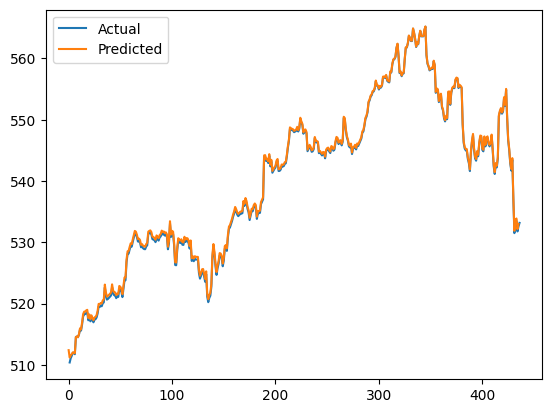

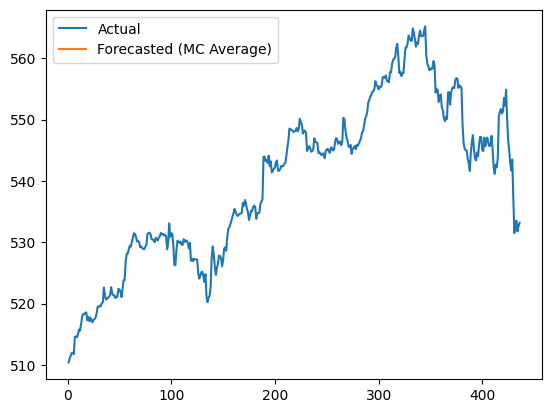

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
MAE: 0.98
RMSPE: 0.27%


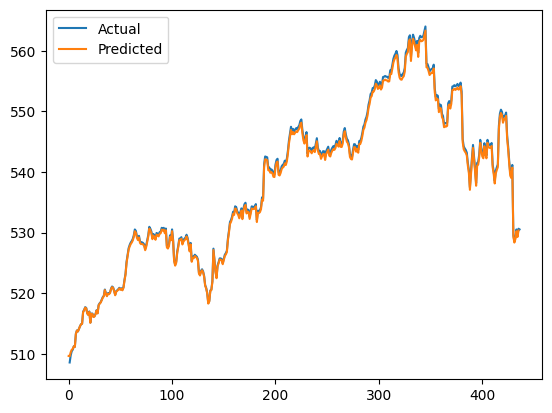

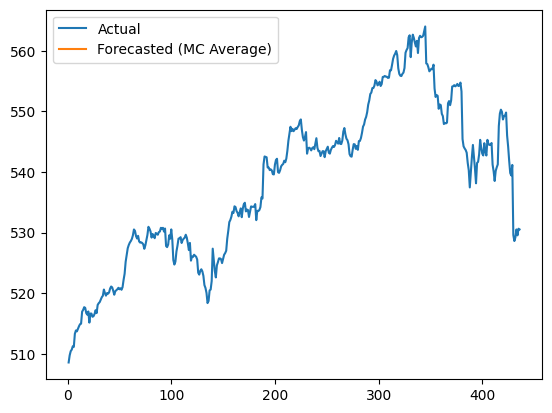

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAE: 1.07
RMSPE: 0.29%


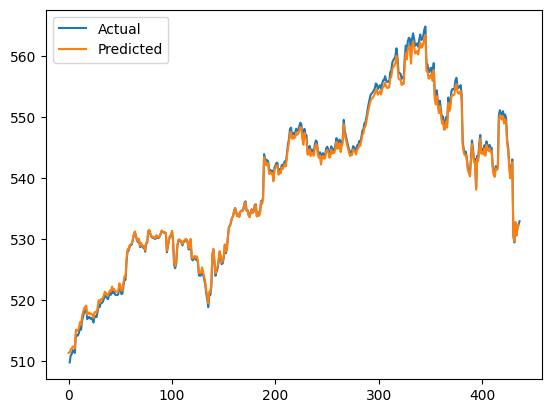

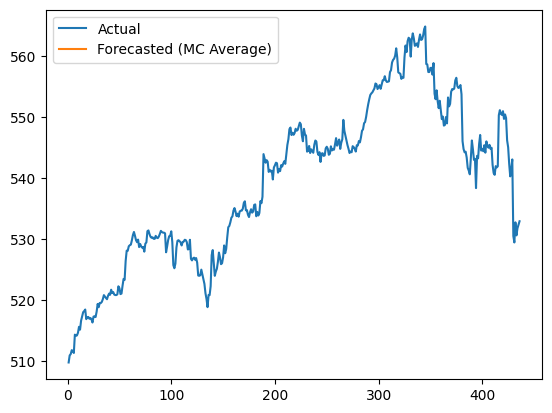

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

FNGU
High



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MAE: 7.58
RMSPE: 2.29%


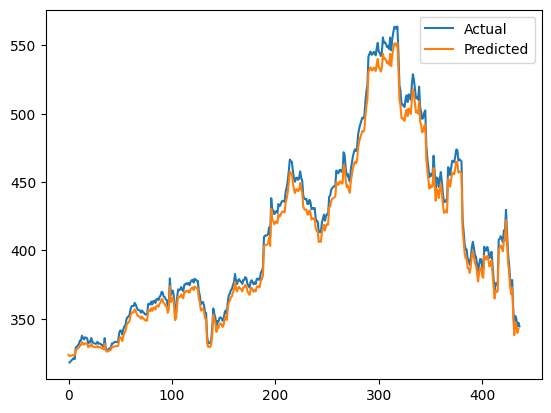

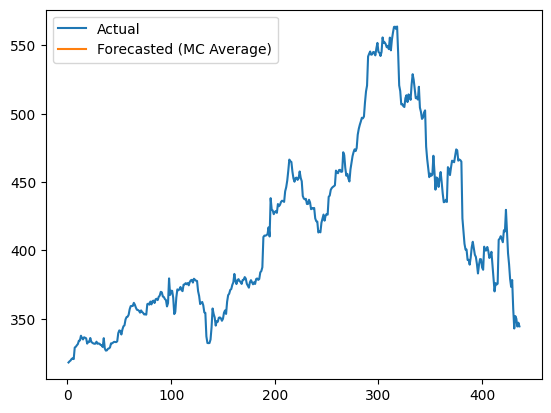

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
MAE: 6.19
RMSPE: 2.09%


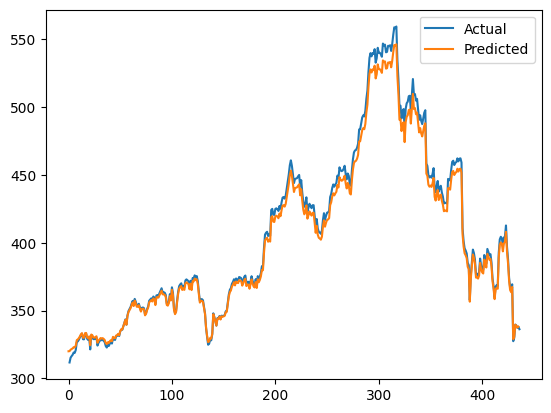

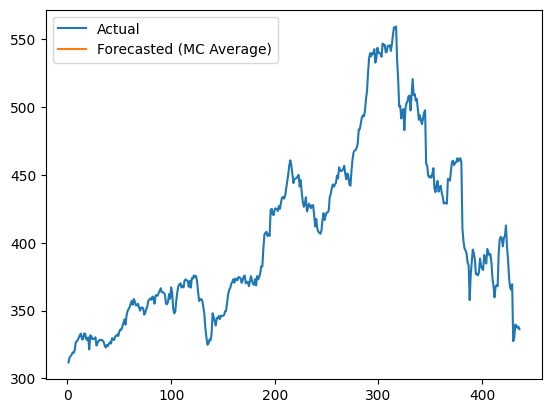

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAE: 4.57
RMSPE: 1.68%


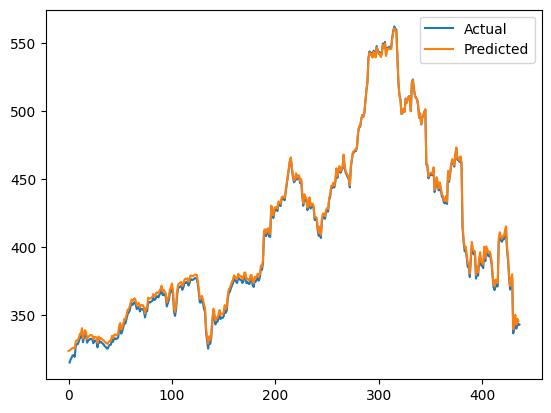

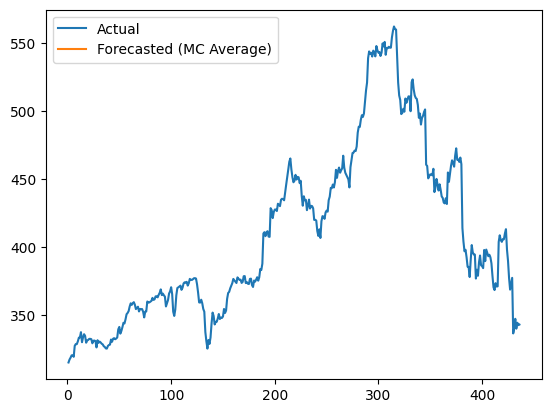

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

AAPL



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MAE: 0.92
RMSPE: 0.66%


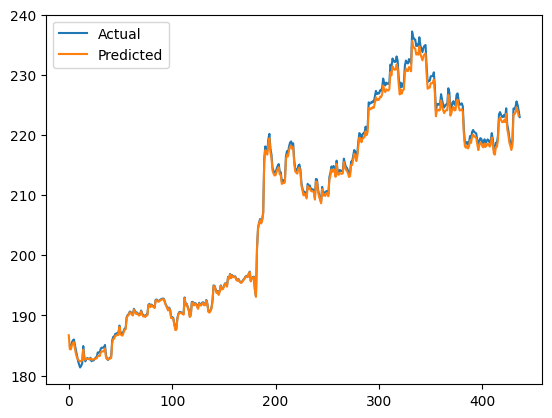

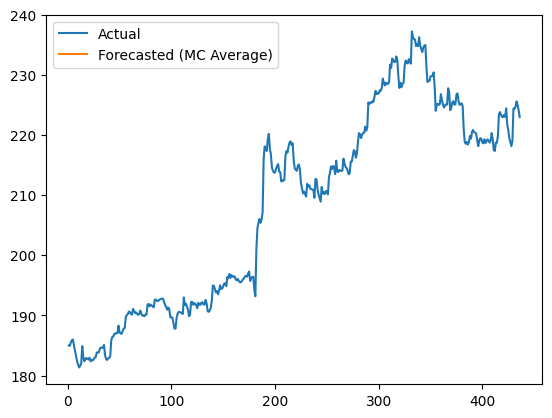

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
MAE: 1.24
RMSPE: 0.80%


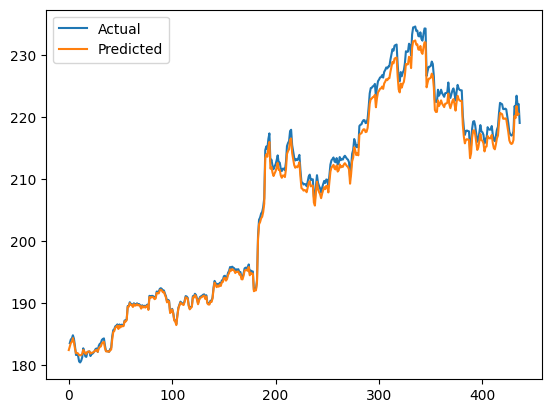

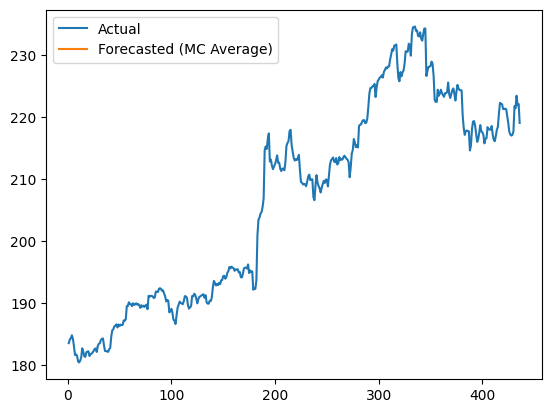

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MAE: 1.19
RMSPE: 0.76%


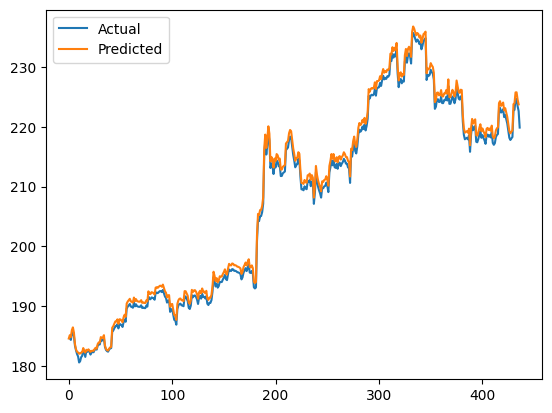

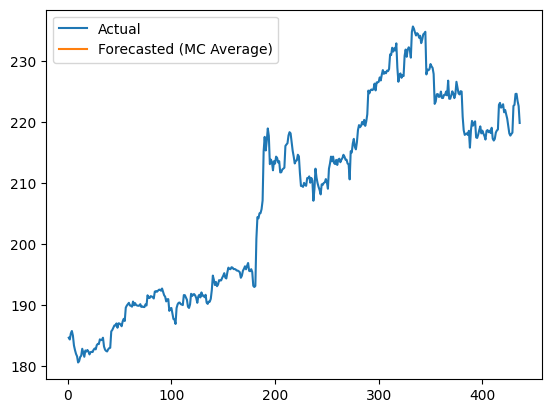

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

TSLA
High



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
MAE: 1.93
RMSPE: 1.56%


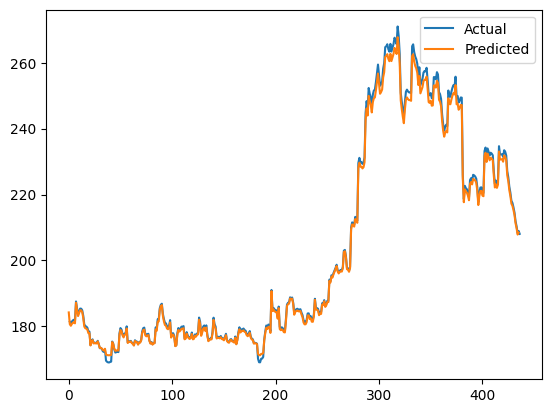

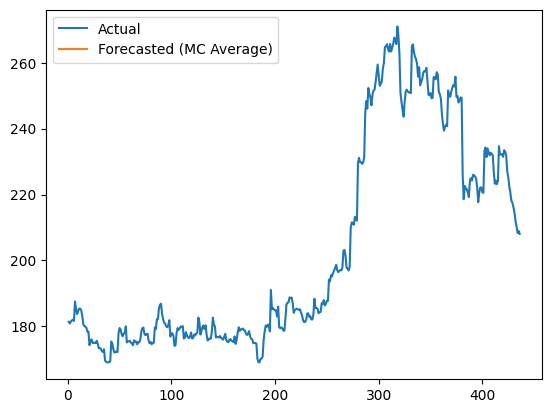

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
MAE: 1.87
RMSPE: 1.52%


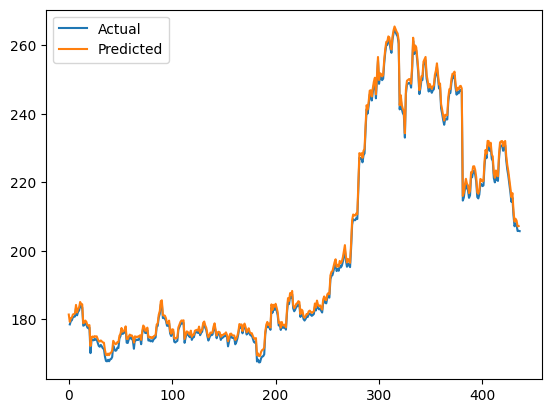

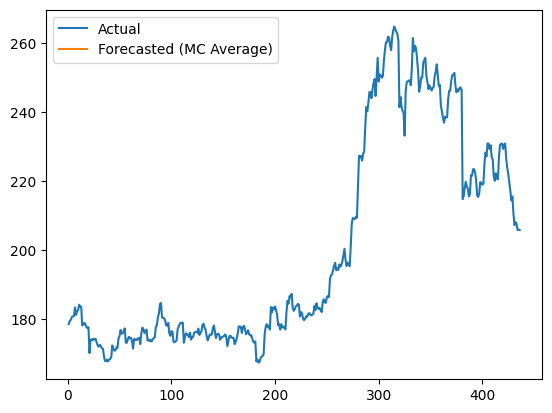

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
MAE: 1.88
RMSPE: 1.56%


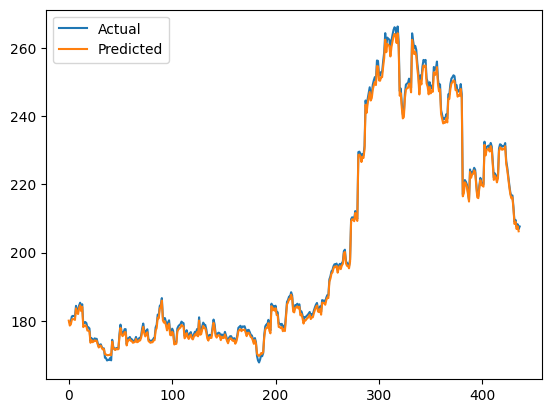

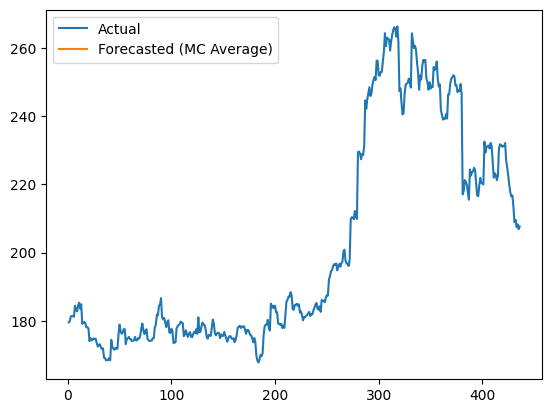

[*********************100%%**********************]  1 of 1 completed


AXP


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
MAE: 0.77
RMSPE: 0.50%


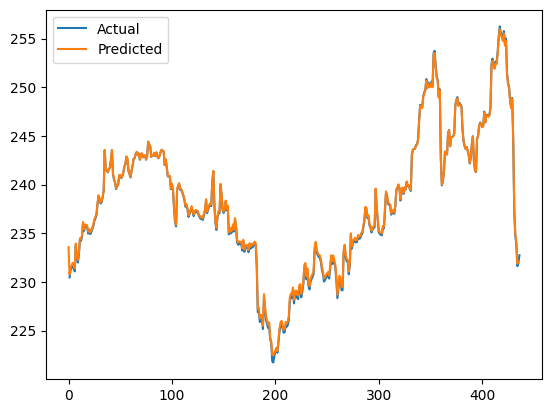

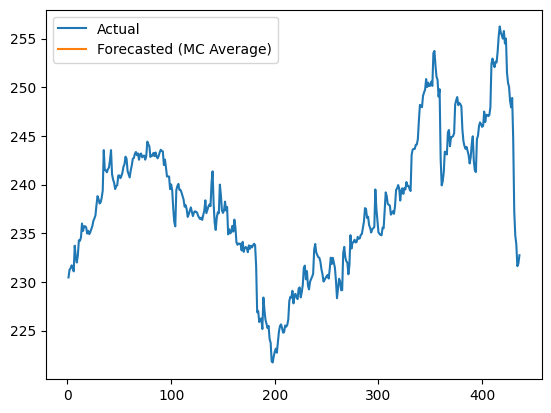

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
MAE: 1.08
RMSPE: 0.61%


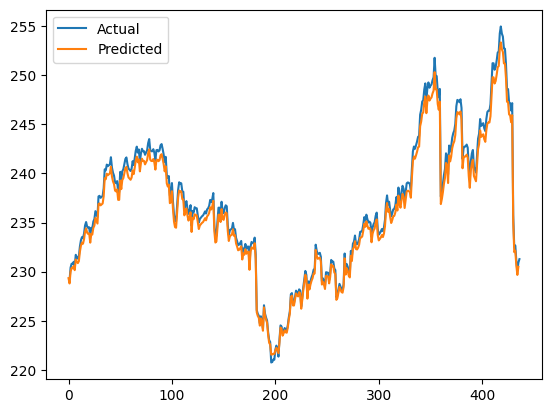

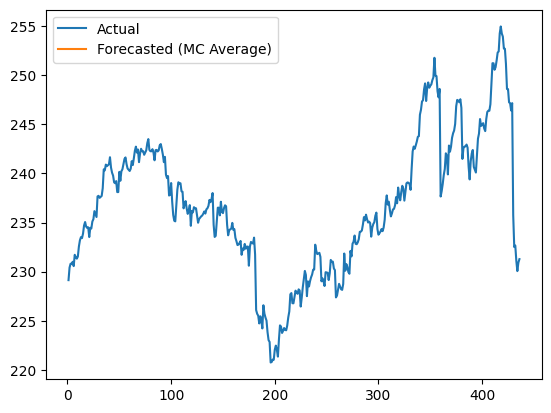

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
MAE: 0.79
RMSPE: 0.56%


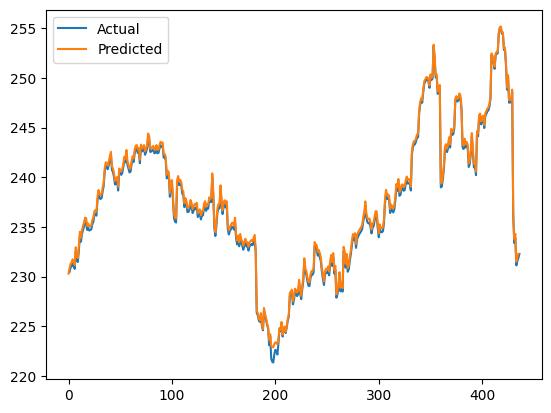

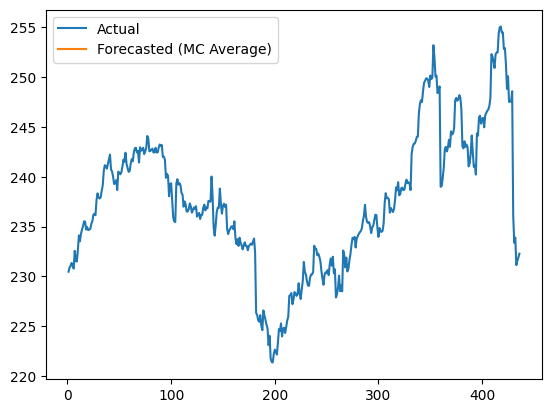

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

AMGN



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
MAE: 1.21
RMSPE: 0.57%


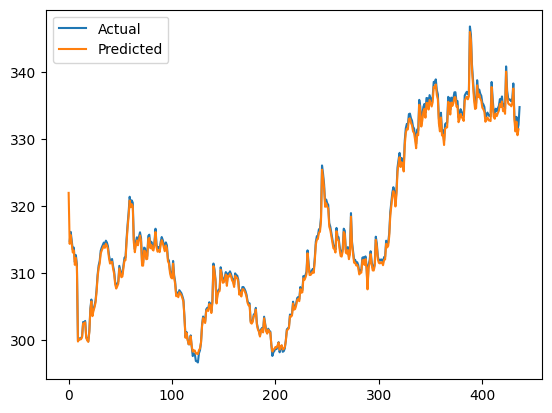

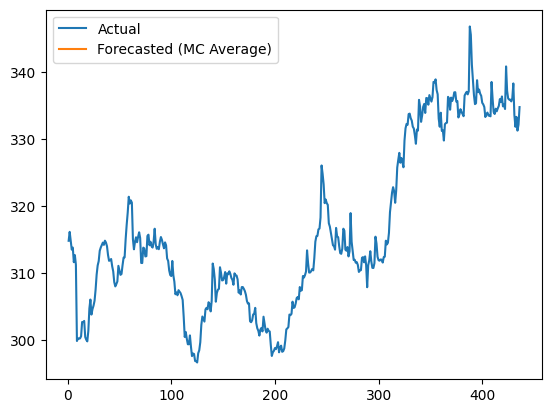

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
MAE: 1.06
RMSPE: 0.49%


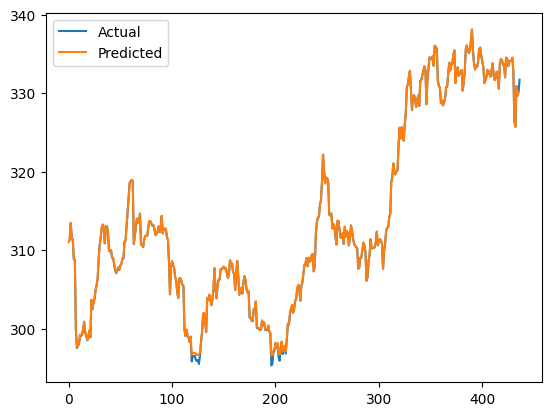

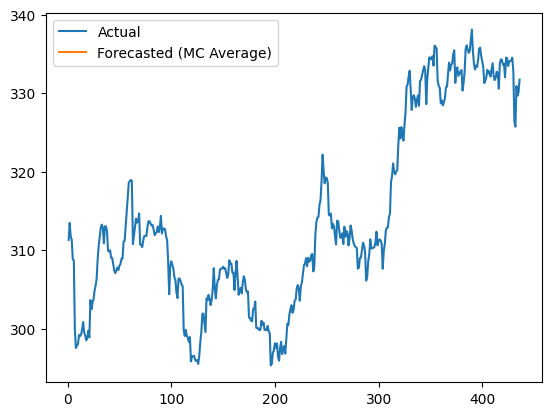

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
MAE: 1.28
RMSPE: 0.57%


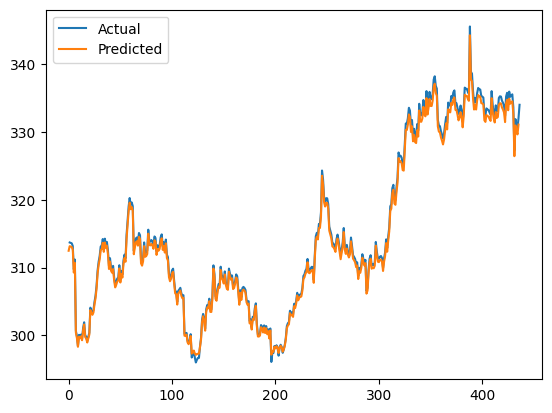

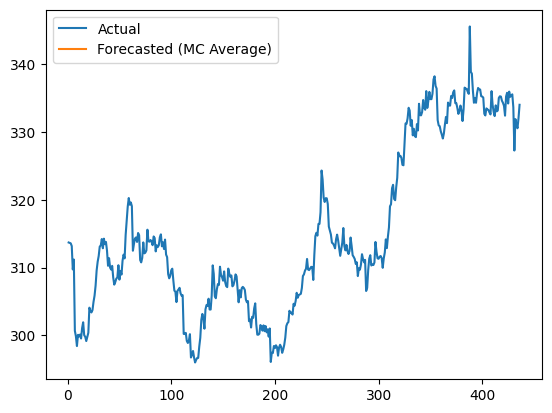

[*********************100%%**********************]  1 of 1 completed


BA


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
MAE: 1.08
RMSPE: 0.84%


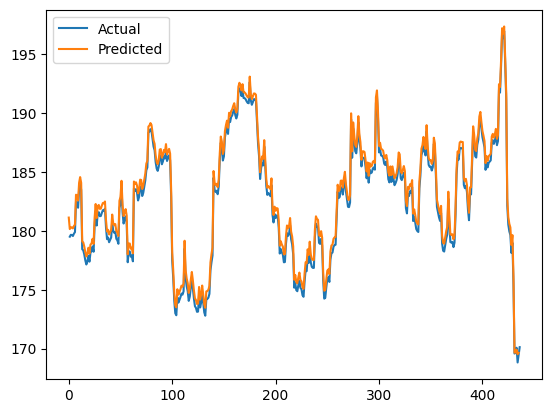

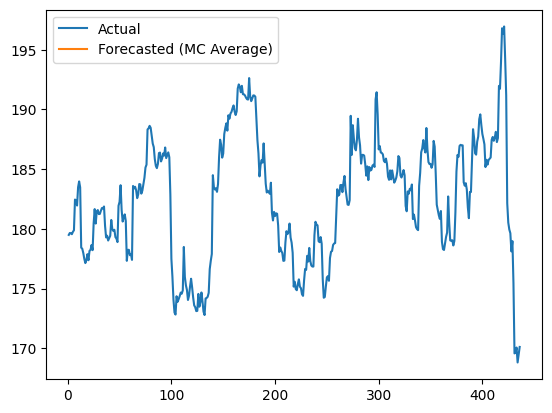

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
MAE: 1.04
RMSPE: 0.84%


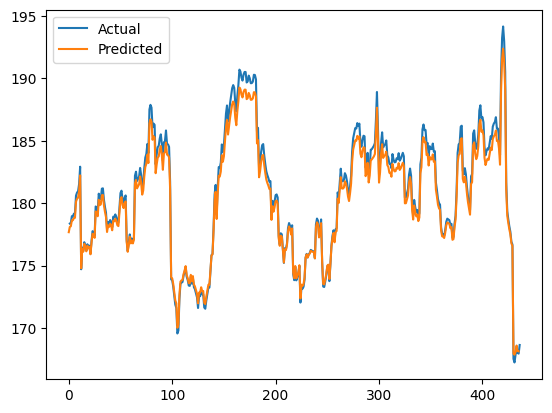

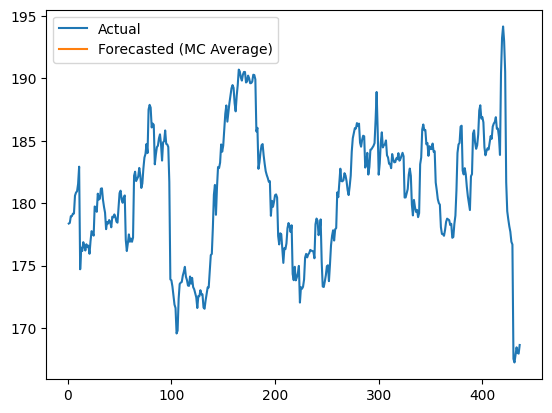

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
MAE: 1.06
RMSPE: 0.85%


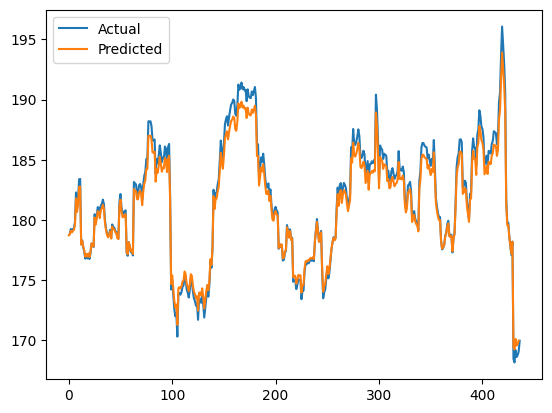

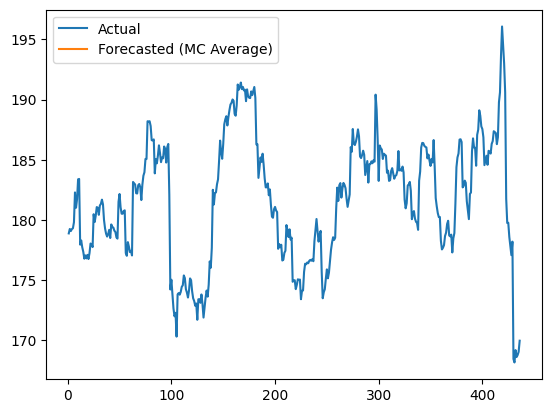

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,index,Ticker,High,Low,Close,Prev High Price,Prev Low Price,Prev Close Price,High Price Difference,High Price Difference Percentage,Low Price Difference,Low Price Difference Percentage,Close Price Difference,Close Price Difference Percentage,Low to High Difference,Low to High Difference Percentage,Forecasted High vs Prev Close Difference,Forecasted High vs Prev Close Difference Percentage
0,0,SPY,533.539978,530.229980,532.900024,536.99,528.6,532.9,-3.45,-0.64,1.63,0.31,0.0,0.0,4.94,0.93,0.64,0.12
1,1,FNGU,339.709991,336.480011,345.920013,357.38,327.29,343.0,-17.67,-4.94,9.19,2.81,2.92,0.85,12.42,3.79,-3.29,-0.96
2,2,AAPL,222.130005,217.610001,220.970001,225.6,217.71,219.86,-3.47,-1.54,-0.1,-0.05,1.11,0.5,4.42,2.03,2.27,1.03
3,3,TSLA,207.589996,207.149994,207.080002,216.13,205.78,207.67,-8.54,-3.95,1.37,0.67,-0.59,-0.28,1.81,0.88,-0.08,-0.04
4,4,AXP,232.990005,230.820007,232.679993,244.65,230.05,232.28,-11.66,-4.77,0.77,0.33,0.4,0.17,2.94,1.28,0.71,0.31
5,5,AMGN,334.100006,331.750000,333.000000,338.35,325.73,333.99,-4.25,-1.26,6.02,1.85,-0.99,-0.3,8.37,2.57,0.11,0.03
6,6,BA,169.960007,168.850006,170.910004,175.46,167.25,169.95,-5.5,-3.13,1.6,0.96,0.96,0.56,2.71,1.62,0.01,0.01


In [8]:
#3mo - 2 future days
three_forcasted = active_forcaster_aggregator()
three_forcasted#.head()

In [ ]:
# ####6mo
#back_forcasted = active_forcaster_aggregator()
#back_forcasted#.head()

In [ ]:
# 1yr
#forcasted = active_forcaster_aggregator()
#forcasted#.head()

In [ ]:
message_1 = f"Good morning, please stand by for your daily forcast."
url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message_1}"
requests.get(url).json()

forcasts = active_forcaster_aggregator()
forcasts.to_csv('forcasted_df.csv', index=False)


message_2 = f'Call if I can be of service. Happy hunting. S Rioghal mo dhream'
url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message_2}"
requests.get(url).json()

forcasts#.head()

In [8]:
import yfinance as yf
import pandas as pd
import yfinance as yf
import pandas as pd

def get_prices(tickers, period='5d'):
    """
    Fetch high, low, and close prices for a list of tickers from Yahoo Finance.

    Parameters:
    tickers (list): List of ticker symbols (e.g. ['AAPL', 'GOOG', 'MSFT'])
    period (str): Time period for which to fetch prices (e.g. '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')

    Returns:
    pd.DataFrame: DataFrame with high, low, and close prices for all tickers
    """
    prices = []
    for ticker in tickers:
        data = yf.download(ticker, period=period)[['High', 'Low', 'Close']]
        data['Ticker'] = ticker
        data.reset_index(inplace=True)
        prices.append(data)
    df = pd.concat(prices)
    df = df[['Date', 'Ticker', 'High', 'Low', 'Close']]
    return df

def filter_by_date(df, date='2024-08-01'):
    """
    Filter a DataFrame to only include rows where the 'Date' column matches the specified date.

    Parameters:
    df (pd.DataFrame): DataFrame to filter
    date (str): Date to filter by (in 'YYYY-MM-DD' format)

    Returns:
    pd.DataFrame: Filtered DataFrame
    """
    filtered_df = df[df['Date'] == date]
    return filtered_df

# Example usage:
tickers = ['SPY', 'FNGU', 'AAPL', 'TSLA', 'AXP', 'AMGN', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD']
df = get_prices(tickers, period='5d')
filtered_df = filter_by_date(df, date='2024-08-02')
filtered_df

[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-41669fc5730c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker
[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-41669fc5730c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker
[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-41669fc5730c>:20: SettingWithCopyWarning: 
A value is trying to be set on a co

,Date,Ticker,High,Low,Close
4,2024-08-02,SPY,536.989990,528.599976,532.900024
4,2024-08-02,FNGU,357.377991,327.290009,343.000000
4,2024-08-02,AAPL,225.600006,217.710007,219.860001
4,2024-08-02,TSLA,216.130005,205.779999,207.669998
4,2024-08-02,AXP,244.649994,230.050003,232.279999
4,2024-08-02,AMGN,338.350006,325.730011,333.989990
4,2024-08-02,BA,175.460007,167.250000,169.949997
4,2024-08-02,CAT,323.399994,317.660004,320.869995
4,2024-08-02,CSCO,47.750000,46.349998,46.660000
4,2024-08-02,CVX,152.039993,147.020004,148.550003


# Forward Testing



In [ ]:
import yfinance as yf
import pandas as pd

def forward_testing():
  # Later, to load the DataFrame from the CSV file
  forcasted_df_loaded = pd.read_csv('forcasted_df.csv')

  # create new columns to store the actual high, low, and close prices and dates
  forcasted_df_loaded['Actual High Price'] = None
  forcasted_df_loaded['Actual Low Price'] = None
  forcasted_df_loaded['Actual Close Price'] = None
  forcasted_df_loaded['Date'] = None
  forcasted_df_loaded['High Price Difference'] = None
  forcasted_df_loaded['High Price Difference Percentage'] = None
  forcasted_df_loaded['Low Price Difference'] = None
  forcasted_df_loaded['Low Price Difference Percentage'] = None
  forcasted_df_loaded['Close Price Difference'] = None
  forcasted_df_loaded['Close Price Difference Percentage'] = None

  # iterate over each row in the DataFrame
  for index, row in forcasted_df_loaded.iterrows():
      ticker = row['Ticker']
      forecasted_high_price = round(float(row['High']), 2)
      forecasted_low_price = round(float(row['Low']), 2)
      forecasted_close_price = round(float(row['Close']), 2)

      # fetch the historical data for the ticker for the last available day
      stock_data = yf.download(ticker, period='1d')

      # extract the actual high, low, and close prices and date from the historical data
      actual_high_price = round(stock_data['High'].iloc[-1], 2)
      actual_low_price = round(stock_data['Low'].iloc[-1], 2)
      actual_close_price = round(stock_data['Close'].iloc[-1], 2)
      high_price_date = stock_data.index[-1].date()

      # update the 'Actual High Price', 'Actual Low Price', 'Actual Close Price', and 'Date' columns
      forcasted_df_loaded.at[index, 'Actual High Price'] = actual_high_price
      forcasted_df_loaded.at[index, 'Actual Low Price'] = actual_low_price
      forcasted_df_loaded.at[index, 'Actual Close Price'] = actual_close_price
      forcasted_df_loaded.at[index, 'Date'] = high_price_date

      # calculate the price differences and percentage differences
      high_price_difference = round(actual_high_price - forecasted_high_price, 2)
      high_price_difference_percentage = round((high_price_difference / actual_high_price) * 100, 2)
      low_price_difference = round(actual_low_price - forecasted_low_price, 2)
      low_price_difference_percentage = round((low_price_difference / actual_low_price) * 100, 2)
      close_price_difference = round(actual_close_price - forecasted_close_price, 2)
      close_price_difference_percentage = round((close_price_difference / actual_close_price) * 100, 2)

      # update the 'High Price Difference', 'High Price Difference Percentage', 'Low Price Difference', 'Low Price Difference Percentage', 'Close Price Difference', and 'Close Price Difference Percentage' columns
      forcasted_df_loaded.at[index, 'High Price Difference'] = high_price_difference
      forcasted_df_loaded.at[index, 'High Price Difference Percentage'] = high_price_difference_percentage
      forcasted_df_loaded.at[index, 'Low Price Difference'] = low_price_difference
      forcasted_df_loaded.at[index, 'Low Price Difference Percentage'] = low_price_difference_percentage
      forcasted_df_loaded.at[index, 'Close Price Difference'] = close_price_difference
      forcasted_df_loaded.at[index, 'Close Price Difference Percentage'] = close_price_difference_percentage

  # set the 'Date' column as the index
  forcasted_df_loaded.set_index('Date', inplace=True)

  # reset the index to a single index
  forcasted_df_loaded = forcasted_df_loaded.reset_index()

  forcasted_df_loaded.to_csv('forward_test_df.csv', index=False)


  forcasted_df_loaded.to_csv('forward_test_df.csv', index=False)

# Add techincal indicators
Shotgun then refine with feature engineerinng


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np

def ti_get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "3mo" #must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"
    interval = "1h"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info

    # Extract the market cap
    #market_cap = ticker_info['marketCap']

    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate the MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate Bollinger Bands
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_Upper'] = data['BB_Middle'] + 2*data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['BB_Middle'] - 2*data['Close'].rolling(window=20).std()

    # Calculate Average Directional Index (ADX)
    data['ATR'] = np.sqrt((data['High'] - data['Low'])**2 + (data['High'] - data['Close'].shift(1))**2 + (data['Low'] - data['Close'].shift(1))**2)
    data['DM_plus'] = np.where((data['High'] - data['High'].shift(1)) > (data['Low'].shift(1) - data['Low']), data['High'] - data['High'].shift(1), 0)
    data['DM_minus'] = np.where((data['Low'].shift(1) - data['Low']) > (data['High'] - data['High'].shift(1)), data['Low'].shift(1) - data['Low'], 0)
    data['DM_plus_14'] = data['DM_plus'].rolling(window=14).sum()
    data['DM_minus_14'] = data['DM_minus'].rolling(window=14).sum()
    data['DI_plus'] = data['DM_plus_14'] / data['ATR'].rolling(window=14).sum()
    data['DI_minus'] = data['DM_minus_14'] / data['ATR'].rolling(window=14).sum()
    data['DX'] = np.abs(data['DI_plus'] - data['DI_minus']) / (data['DI_plus'] + data['DI_minus'])
    data['ADX'] = data['DX'].rolling(window=14).mean()

    # Calculate On-Balance Volume (OBV)
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'], np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()

    # Calculate Volume Moving Average
    data['VMA_50'] = data['Volume'].rolling(window=50).mean()
    data['VMA_200'] = data['Volume'].rolling(window=200).mean()

    # Calculate Average True Range (ATR)
    data['ATR_14'] = data['ATR'].rolling(window=14).mean()

    # Calculate Volatility Index (VIX)
    data['VIX'] = data['ATR_14'] / data['Close']

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

#ticker = 'SPY'
#numeric = get_numeric_data(ticker)
#numeric.tail()

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import Input, LeakyReLU

def ti_gru_forcast(target, df, future_days):
    print(target)
    num_mc_simulations=100
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[[target]]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the bidirectional-GRU model

    model = Sequential()
    model.add(Input(shape=(seq_len, 1)))
    model.add(GRU(units=1000, return_sequences=True, activation='relu'))
    model.add(Dropout(0.26))
    model.add(GRU(units=200, return_sequences=True, activation='relu'))
    model.add(Dropout(0.26))
    model.add(GRU(units=1000, return_sequences=False, activation='relu'))
    model.add(Dropout(0.26))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])
    #model.save('gru_model_pred-for.keras')

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Calculate actual prices
    actual_prices = close_df[seq_len:].values

    # Calculate MAE
    mae = np.mean(np.abs(actual_prices - predictions_rescaled))
    print(f'MAE: {mae:.2f}')

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean((actual_prices - predictions_rescaled) ** 2)) / np.mean(actual_prices) * 100
    print(f'RMSPE: {rmspe:.2f}%')

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    #future high
    future_close_prices_mc = []
    for _ in range(num_mc_simulations):
        future_close_prices = []
        last_seq_mc = scaled_close[-seq_len:]
        last_seq_mc = last_seq_mc.reshape((1, seq_len, 1))
        for i in range(future_days):
            predictions = model.predict(last_seq_mc, verbose=0)
            predictions_rescaled = scaler.inverse_transform(predictions)
            future_close_prices.append(predictions_rescaled[0, 0])
            predictions = predictions.reshape((1, 1, 1));  # Reshape predictions to (1, 1, 1)
            last_seq_mc = np.append(last_seq_mc[:, 1:, :], predictions, axis=1)
        future_close_prices_mc.append(future_close_prices)

    # Calculate the Monte Carlo average
    future_close_prices_mc_avg = np.mean(future_close_prices_mc, axis=0)

    # Plot forecasted prices
    plt.plot(close_df[seq_len:], label='Actual')
    #plt.plot(predictions_rescaled, label='Predicted')
    plt.plot(range(len(close_df[seq_len:]), len(close_df[seq_len:])+future_days), future_close_prices_mc_avg, label='Forecasted (MC Average)')
    plt.legend()
    plt.show()

    return future_close_prices_mc_avg

In [ ]:
def ti_forecast_pipeline(ticker, future_days):
  print(ticker)
  forcasted_df = pd.DataFrame()

  #data
  df = ti_get_numeric_data(ticker)

  #forcasts
  forcasted_df['High']  = ti_gru_forcast('High', df, future_days)
  forcasted_df['Low'] = ti_gru_forcast('Low', df, future_days)
  forcasted_df['Close'] =  ti_gru_forcast('Close', df, future_days)

  # Round all values to 2 decimal places
  forcasted_df = forcasted_df.round(2)

  return forcasted_df

In [ ]:
ticker = 'SPY'
future_days=1
forcasted_df = ti_forecast_pipeline(ticker, future_days)
forcasted_df.head()

# Feature importance


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.utils import check_array
import numpy as np
def gru_importance(target, df, future_days):
    print(target)
    num_mc_simulations=100
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[[target]]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the GRU model
    model = Sequential()
    model.add(Input(shape=(seq_len, 1)))
    model.add(GRU(units=1000, return_sequences=True, activation='relu'))
    model.add(Dropout(0.26))
    model.add(GRU(units=200, return_sequences=True, activation='relu'))
    model.add(Dropout(0.26))
    model.add(GRU(units=1000, return_sequences=False, activation='relu'))
    model.add(Dropout(0.26))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Calculate actual prices
    actual_prices = close_df[seq_len:].values

    # Calculate MAE
    mae = np.mean(np.abs(actual_prices - predictions_rescaled))
    print(f'MAE: {mae:.2f}')

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean((actual_prices - predictions_rescaled) ** 2)) / np.mean(actual_prices) * 100
    print(f'RMSPE: {rmspe:.2f}%')

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    def permutation_importance_3d(model, X, y, n_repeats=10, random_state=42):
        X = check_array(X)
        y = check_array(y)

        results = []
        for i in range(X.shape[2]):
            X_permuted = X.copy()
            for j in range(n_repeats):
                np.random.shuffle(X_permuted[:, :, i])
                y_pred = model.predict(X_permuted)
                results.append(mean_squared_error(y, y_pred))

        importances = np.array(results).reshape((X.shape[2], n_repeats)).mean(axis=1)
        return importances

    # Calculate permutation importance
    permutation_importances = permutation_importance_3d(model, X_train, y_train, n_repeats=10, random_state=42)
    print(permutation_importances)

    # Plot permutation importance
    plt.bar(range(X_train.shape[2]), permutation_importances)
    plt.xlabel('Feature Index')
    plt.ylabel('Permutation Importance')
    plt.show()

ticker = 'SPY'
df = ti_get_numeric_data(ticker)
future_days=1
gru_importance('High', df, future_days)

In [ ]:
ticker = 'SPY'
df = ti_get_numeric_data(ticker)
future_days=1
gru_importance('Low', df, future_days)

In [ ]:
ticker = 'SPY'
df = ti_get_numeric_data(ticker)
future_days=1
gru_importance('Close', df, future_days)

In [ ]:
#forward_testing()
#forward_df = pd.read_csv('forward_test_df.csv')
#forward_df.head()

# FNGU Optimization

In [ ]:
def fngu_get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "3mo" #must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"
    interval = "1h"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info

    # Extract the market cap
    #market_cap = ticker_info['marketCap']

    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate the MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

#ticker = 'SPY'
#numeric = get_numeric_data(ticker)
#numeric.head()

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Bidirectional, GRU, Dropout, Dense
from keras.layers import Attention

def fngu_gru_forcast(target, df, future_days):
    print(target)
    num_mc_simulations=100
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[[target]]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the GRU model
    model = Sequential()
    model.add(Bidirectional(GRU(units=1500, return_sequences=True, input_shape=(seq_len, 1), activation='relu')))
    model.add(Dropout(0.26))
    model.add(Bidirectional(GRU(units=300, return_sequences=True, activation='relu')))
    model.add(Dropout(0.26))
    model.add(Bidirectional(GRU(units=1500, return_sequences=False, activation='relu')))
    model.add(Dropout(0.26))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])
    #model.save('gru_model_pred-for.keras')

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Calculate actual prices
    actual_prices = close_df[seq_len:].values

    # Calculate MAE
    mae = np.mean(np.abs(actual_prices - predictions_rescaled))
    print(f'MAE: {mae:.2f}')

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean((actual_prices - predictions_rescaled) ** 2)) / np.mean(actual_prices) * 100
    print(f'RMSPE: {rmspe:.2f}%')

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    #future high
    future_close_prices_mc = []
    for _ in range(num_mc_simulations):
        future_close_prices = []
        last_seq_mc = scaled_close[-seq_len:]
        last_seq_mc = last_seq_mc.reshape((1, seq_len, 1))
        for i in range(future_days):
            predictions = model.predict(last_seq_mc, verbose=0)
            predictions_rescaled = scaler.inverse_transform(predictions)
            future_close_prices.append(predictions_rescaled[0, 0])
            predictions = predictions.reshape((1, 1, 1));  # Reshape predictions to (1, 1, 1)
            last_seq_mc = np.append(last_seq_mc[:, 1:, :], predictions, axis=1)
        future_close_prices_mc.append(future_close_prices)

    # Calculate the Monte Carlo average
    future_close_prices_mc_avg = np.mean(future_close_prices_mc, axis=0)

    # Plot forecasted prices
    plt.plot(close_df[seq_len:], label='Actual')
    #plt.plot(predictions_rescaled, label='Predicted')
    plt.plot(range(len(close_df[seq_len:]), len(close_df[seq_len:])+future_days), future_close_prices_mc_avg, label='Forecasted (MC Average)')
    plt.legend()
    plt.show()

    return future_close_prices_mc_avg



#ticker = 'FNGU'
#df = numeric_sentiment_pipeline(ticker)
#future_close_prices_mc_avg = gru_forcast(df, future_days=30, num_mc_simulations=100)
#print("Future High prices (MC Average):", future_close_prices_mc_avg)

In [ ]:

ticker = 'SPY'
forcasted_df = fngu_forecast_pipeline(ticker, future_days=1)


In [ ]:
def fngu_forecast_pipeline(ticker, future_days):
  print(ticker)
  forcasted_df = pd.DataFrame()

  #data
  df = fngu_get_numeric_data(ticker)

  #forcasts
  forcasted_df['High']  = fngu_gru_forcast('High', df, future_days)
  forcasted_df['Low'] = fngu_gru_forcast('Low', df, future_days)
  forcasted_df['Close'] =  fngu_gru_forcast('Close', df, future_days)

  # Round all values to 2 decimal places
  forcasted_df = forcasted_df.round(2)

  return forcasted_df

#ticker_list = ['SPY','FNGU']
#future_days=1
#predictions=[]
#for ticker in ticker_list:
    #prediction = forecast_pipeline(ticker, future_days)
    #send_forcast(ticker, prediction)
    #predictions.append(prediction)  # append each prediction to the list
    #predictions.append({'Ticker': ticker, 'Prediction': prediction})  # append each prediction to the list
    #print(prediction)
